# BE : Segmentation d'images satellites avec PyTorch
ISAE-SUPAERO

Auteur : Adrien Lagrange (adrien.lagrange@airbus.com)

Le but de ce TP est de se confronter à un problème de Deep Learning concret.
Plus précisément, on cherche à résoudre un problème de segmentation à l'aide d'un réseau de neurones profonds.
Ce type de problème est un des plus classiques après la classification d'images (cas déjà traité par exemple dans le cours d'introduction à Pytorch).

La classification vise à attribuer un label à une image donnée en se basant sur un ensemble de classes prédéfinies, par exemple les chiffres manuscrits (MNIST) ou des classes d'objets (CIFAR-10). Lorsqu'on parle de segmentation, on ne cherche plus à donner une classe par image mais plutôt une classe par pixel de l'image.

Dans le contexte de la conduite autonome, on cherchera par exemple à identifier dans l'image les zones correspondant à la route, aux panneaux, aux autres voitures, etc.
Pour ce TP, on s'intéresse à une tâche de segmentation appliquée à l'imagerie satellite. Le but est d'**entrainer un réseau de neurones à segmenter les nuages** présents dans des images satellites multi-spectrales, c'est-à-dire avec plusieurs canaux correspondant chacun à une longueur d'onde spécifique, typiquement dans le visible ou dans l'infrarouge.

Ce TP s'attachera d'une part à montrer les spécificités des problèmes de segmentation et d'autre part à se confronter à un dataset réaliste de sorte à mettre en lumière les problèmes survenant lorsqu'on s'éloigne des datasets standards utilisés dans la plupart des cours/exemples disponibles en ligne.

Le déroulé du TP reproduit les étapes à réaliser lors du développement d'une solution de Deep Learning :

1. L'analyse et la préparation des données
2. La préparation de l'architecture du réseau
3. La préparation de l'apprentissage
4. L'apprentissage
5. L'analyse des résultats


## Consigne

Ce TP est noté et chaque binome doit rendre le TP sous forme de notebook. En plus du code à compléter, il faudra répondre aux questions en utilisant des blocs de texte comme celui-ci. Il ne faut également pas hésiter à commenter/critiquer les résultats.

Attention, le code ne sera pas reexécuté par le correcteur donc faites attention d'exporter le notebook en conservant les sorties que vous souhaitez montrer.

## Préparation de l'environnement

Avant toute chose, commençons par importer un ensemble de librairies utiles pour ce TD et par vérifier la disponibilité d'un GPU pour accélérer l'apprentissage. Le code ci-dessous DOIT renvoyer 'True' à la question sur la disponibilité d'un GPU. Si ce n'est pas le cas, l'environnement n'a dû être lancé correctement.

In [1]:
## Standard libraries
import os
import math
import numpy as np
import time
import typing
import ast
from tqdm.notebook import tqdm

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import to_rgba

## Imports torch
import torch
print("Using torch", torch.__version__)

## Torch setup
os.environ['GPU_NUM_DEVICES'] = '1'
torch.manual_seed(42) # Setting the seed
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Using torch 1.13.1+cu117
Is the GPU available? True
Device cuda


In [2]:
# Installation de librairies non disponibles par défaut
%pip install albumentations
%pip install torchinfo
%pip install rasterio

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import de librairies utiles pour manipuler des images ou faciliter l'utilisation de Torch
import rasterio
import pandas as pd
import albumentations as album
from albumentations.pytorch import ToTensorV2 as ToTensor
import cv2
from torchinfo import summary

# Analyser et préparer des données

## Récupérer les données

Comme annoncé dans l'introduction, la première étape est l'analyse de la base de données utilisée et sa préparation.
Cette étape est indispensable avant de se pencher sur l'apprentissage en lui-même.
La compréhension exact du problème guidera par la suite les choix des méthodes utilisées et facilitera l'analyse des résultats.

Commençons par récupérer la base de données. Exécutez la cellule de code ci-dessous qui permettent de décompresser la base de données.

Si tout s'est bien déroulé un nouveau dossier nommé *subset_supaero/*, contenant la base de données, se trouve maintenant dans votre environnement.

In [4]:
!tar xzf ./subset_supaero.tgz
!rm ./subset_supaero.tgz

## Organisation des données

Dans un projet de deep learning, l'organisation du dataset est presque systématiquement la même et il est primordial de comprendre la logique sous-jacente.
Les données sont séparées en 3 ensembles appelés respectivement l'ensemble d'entrainement, de validation et de test.

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.bualabs.com%2Fwp-content%2Fuploads%2F2019%2F07%2Ftrain-validation-test-split-data-1.jpg&f=1&nofb=1&ipt=f67d8f03c048c4d189ee31763fdda4c689b7a1e868cfc632724da21b49c0e4b8&ipo=images" alt="drawing" width="400"/>

> **Ensemble d'entrainement** -- Cet ensemble va être utilisé pour "entrainer" le modèle, c'est-à-dire pour ajuster les paramètres du réseaux (filtres, biais, etc.). Pour cela, on définit un problème d'optimisation visant à minimiser l'erreur de prédiction du réseau sur cet ensemble.

> **Ensemble de validation** -- Cet ensemble va également servir durant l'apprentissage afin de controler le comportement du réseau sur des images qui n'ont pas été vues par le réseau durant l'apprentissage. On pourra en particulier controler la convergence de la fonction de coût et identifier des phénomènes comme le surapprentissage. Le comportement du réseau sur cet ensemble permet d'optimiser manuellement ce qu'on appelle les hyperparamètres. Les hyperparamètres sont tous les paramètres controlant le processus d'apprentissage (learning rate, taille de batch, fonction de coût, pénalisation, etc.) et aussi les paramètres du modèles qui ne sont pas modifiés durant l'apprentissage tel que l'architecture du réseau.

> **Ensemble de test** -- Cet ensemble est utilisé pour avoir une évaluation non biaisée des performances du réseau sur des images qui n'ont servi ni à l'apprentissage ni à l'ajustement des hyperparamètres.

Une répartition typique entre les différents ensembles est de l'ordre de 70% des données pour l'entrainement, 20% pour la validation, 10% pour le test. Cependant, ces proportions peuvent variées suivant la taille du dataset. On souhaite utiliser le maximum de données possible pour l'entrainement tout en ayant une quantité de données suffisante pour avoir une évaluation fiable pour la validation et le test.

Dans le cas de ce TD, on se contentera, par manque de temps, d'utiliser un ensemble d'entrainement et de validation, même si une évaluation plus rigoureuse nécessiterait un ensemble de test additionnel.
Les images étant toutes mélangées, deux csv listent les images constituant respectivement l'ensemble d'entrainement et de validation.

In [4]:
# Paths to train and validation csv + image folder
train_csv = "./subset_supaero/trainset.csv"
eval_csv = "./subset_supaero/validset.csv"
img_folder = "./subset_supaero/"

Les données du TD sont un sous-ensemble des données utilisées pour une compétition de data science (https://www.drivendata.org/competitions/83/cloud-cover/page/396/).
Les images sont issues d'acquisitions faites dans le cadre de la mission d'observation de la Terre Sentinel-2 (ESA).
Chaque image Sentinel-2 est constituée de 13 bandes spectrales en lumière visible et proche infrarouge avec une résolution comprise entre 10 et 60 mètres suivant les bandes.
Seul les 4 bandes à 10m de résolution ont été fournies dans le dataset de la compétition.

**Retrouvez les bandes utilisées sur le site de la compétition dont le lien est donné plus haut.**

Band	Description	Center wavelength \
B02	Blue visible light - 497 nm \
B03	Green visible light - 560 nm \
B04	Red visible light - 665 nm \
B08	Near infrared light - 835 nm 

Pour permettre une prise en main rapide, la classe CloudDataset permet de facilement lire les données. Elle hérite directement de la classe Dataset de la librairies Pytorch ce qui permettra par la suite de faciliter l'apprentissage notamment en se reposant sur Pytorch pour créer des batches d'images.

In [5]:
# Dataset reader
class CloudDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, img_folder):
        """
        Args:
            dataset: path to a csv file with a row for each image. There must be a column chip_id.
            img_folder: path to the folder containing the images
        """
        self.data = pd.read_csv(dataset)
        self.img_folder = img_folder

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Load dataset information
        img_infos = self.data.loc[idx]

        # Load raster image
        img_path = os.path.join(self.img_folder, img_infos["chip_id"])
        band_arrs = []
        for band in ["B02", "B03", "B04", "B08"]:
            with rasterio.open(os.path.join(img_path, band+".tif")) as b:
                band_arr = b.read(1)
            band_arrs.append(band_arr)
        image = np.stack(band_arrs, axis=-1)

        # Load ground truth mask
        with rasterio.open(os.path.join(img_path, img_infos["chip_id"]+".tif")) as b:
            mask = b.read(1)

        return {"image": image, "mask": mask}

    def plot(self, idx):
        sample = self.__getitem__(idx)

        img = sample["image"][:,:,:3].astype("float32")

        # Constrast enhancement for better visualisation
        img = (img - np.amin(img))/(np.amax(img) - np.amin(img))

        # Plots
        plt.figure()
        plt.grid(False)
        plt.imshow(img[:,:,::-1])
        plt.figure()
        plt.grid(False)
        plt.imshow(sample["mask"], vmin=0, vmax=1)


**Analyser le dataset** pour trouver :

- la taille des images (hauteur, largeur, nombre de canaux)
- la dynamique des images, c'est-à-dire la plage de valeurs prise par les pixels, et leur format (formats possibles : uint8, uint16, float)
- la forme de la vérité terrain fournie avec le dataset
- la qualité de la vérité terrain (votre avis qualitatif sur la vérité terrain après avoir observé plusieurs cas)

On pourra utiliser la méthode plot() de la classe CloudDataset pour afficher des images et leur vérité terrain associée.
Une fois instancié, un objet de cette classe renvoie un dictionnaire contenant une image et son masque de vérité terrain lorsqu'il est indexé.

Exemple :

```
dataset_train = CloudDataset(train_csv, img_folder)
item = dataset_train[108]
# l'image est accessible par item['image'] et le mask par item['mask']
dataset_train.plot(108)
```

N'hésitez pas à modifier la méthode plot ou bien à manipuler directement *item['image']* et *item['mask']* pour faire votre analyse.

Taille de l'image : (512, 512, 4) \
Hauteur : 512 \
Largeur : 512 \
Nombre de bandes : 4\
format image : uint16\
Dynamique image : de 0 à 65535\
format mask : uint8\
Dynamique mask : 1 pour un pixel de nuage, 0 sinon\
La vérité terrain est sous forme de masque, les 1 indiquant des pixels de nuage et les 0 les pixels de sol

Critique de la qualité terrain : \
Nous observons que les masques sont faits avec des lignes droites qui approximent les nuages.\
Nous observons aussi que certains petits bouts de nuages indépendants n'apparaissent pas dans le masque.\
Enfin, certains trous dans les nuages qui laissent apparaîtrent le sol sont classés comme nuage dans la vérité terrain.

Taille de l'image : (512, 512, 4)
Hauteur : 512
Largeur : 512
Nombre de bandes : 4
format image : uint16
Dynamique image : de 0 à 65535
format mask : uint8
Dynamique mask : 1 pour un pixel de nuage, 0 sinon
La vérité terrain est sous forme de masque, les 1 indiquant des pixels de nuage et les 0 les pixels de sol
Critique de la qualité terrain : 
Nous observons que les masques sont faits avec des lignes droites qui approximent les nuages.
Nous observons aussi que certains petits bouts de nuages indépendants n'apparaissent pas dans le masque.
Enfin, certains trous dans les nuages qui laissent apparaîtrent le sol sont classés comme nuage dans la vérité terrain.


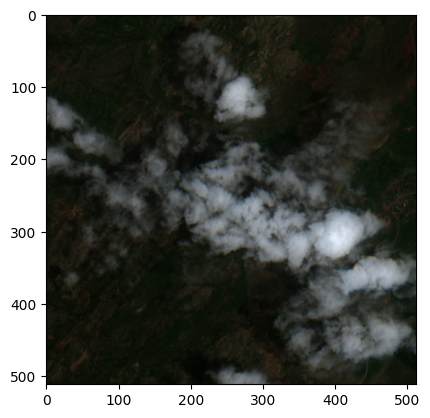

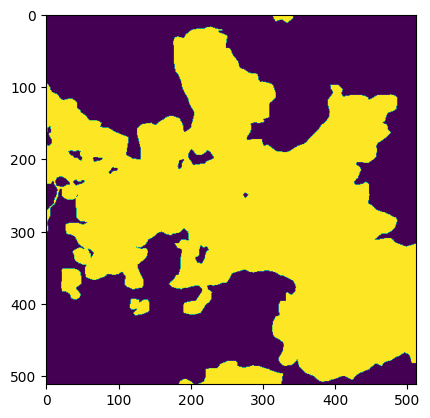

In [6]:
# Instance data generators
dataset_train = CloudDataset(train_csv, img_folder)
dataset_eval = CloudDataset(eval_csv, img_folder)

# Ici utiliser python pour identifier les caractéristiques des données
item = dataset_train[10]
print(f"Taille de l'image : {item['image'].shape}")
print(f"Hauteur : {item['image'].shape[0]}")
print(f"Largeur : {item['image'].shape[1]}")
print(f"Nombre de bandes : {item['image'].shape[2]}")
dataset_train.plot(99)
print(f"format image : {item['image'].dtype}")
print(f"Dynamique image : de 0 à 65535")
print(f"format mask : {item['mask'].dtype}")
print(f"Dynamique mask : 1 pour un pixel de nuage, 0 sinon")
print(f"La vérité terrain est sous forme de masque, les 1 indiquant des pixels de nuage et les 0 les pixels de sol")
print(f"Critique de la qualité terrain : ")
print("Nous observons que les masques sont faits avec des lignes droites qui approximent les nuages.")
print("Nous observons aussi que certains petits bouts de nuages indépendants n'apparaissent pas dans le masque.")
print("Enfin, certains trous dans les nuages qui laissent apparaîtrent le sol sont classés comme nuage dans la vérité terrain.")
#item['image'][0][0][0]
#item['mask'][0]


On notera que la tâche généralement fastidieuse de création des vérités terrain a été réalisée par crowdsourcing pour ce dataset. Cette méthode est efficace pour labéliser de grands quantités mais a tendance à introduire des erreurs et des différences entre les masques faits par différentes personnes.

Avant d'utiliser les images pour l'apprentissage, il est conventionnel de standardiser les données typiquement en les ramenant entre -1 et 1 ou entre 0 et 1. Bien que ce ne soit pas strictement nécessaire, cela évite d'avoir à compenser une dynamique très élevée par des poids (poids = paramètres appris du réseau) très faibles dans les premières couches du réseaux. C'est par contre nécessaire lorsque l'on dispose d'un dataset hétéroclite avec des images provenant de différentes sources et avec des dynamiques différentes.

De plus, pour éviter de dépasser les capacités du GPU, on évite généralement de donner des images trop grandes en entrée du réseau.

On se limitera pour ce TD à des images de tailles 224x224x4 dont la dynamique aura été divisée par 10000.

Pour effectuer ces transformations simplement et à la volée lors de l'apprentissage, on utilise la librairies [albumentation](https://albumentations.ai/docs/).

**Compléter les paramètres des transformations CenterCrop et Normalize dans le bloc de code suivant pour effectuer ces transformations.**

Documentation :

https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Normalize

https://albumentations.ai/docs/api_reference/augmentations/crops/transforms/#albumentations.augmentations.crops.transforms.CenterCrop

In [7]:
transform_train = album.Compose([
    album.CenterCrop(224,224),
    album.Normalize(mean=(0, 0, 0, 0), std=(1, 1, 1, 1), max_pixel_value=10000.0),
    ToTensor(),
])

transform_eval = album.Compose([
    album.CenterCrop(224,224),
    album.Normalize(mean=(0, 0, 0, 0), std=(1, 1, 1, 1), max_pixel_value=10000.0),
    ToTensor(),
])

La classe TransformedDataset ci-dessous permet d'encapsuler le mécanisme de transformation et peut être utiliser comme la classe CloudDataset mais retournera les images après leur avoir appliqué les transformations définies.

**Modifiez la méthode plot() de cette classe pour ajouter des tests/print pour vérifier que les transformations sont celles attendues.**

In [8]:
# Augmentations
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, ds, transform_fn):
        assert isinstance(ds, torch.utils.data.Dataset)
        assert callable(transform_fn)

        super(TransformedDataset, self).__init__()

        self.ds = ds
        self.transform_fn = transform_fn

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, index):
        item = self.ds[index]
        item['image'] = item['image'].astype("float32")
        item['mask'] = item['mask'].astype("float32")

        return self.transform_fn(**item)

    def plot(self, idx):
        sample = self.__getitem__(idx)

        img = np.transpose(sample["image"].numpy(), (1,2,0))
        print(img.dtype)

        # Ecrire ici quelques tests pour vérifier que les images ont bien subi les transformations souhaitées
        #####################################################
        assert((img.shape[0] == 224) & (img.shape[1] == 224) & (img.shape[2] == 4))
        #assert(img.shape[0]==224)
        print(img.shape)
        item = self.ds[idx]
        #item['image'] = item['image'].astype("float32")
        print(f"max avant transf. : {np.max(item['image'][144:368,144:368,:])} (sur l'image crop au milieu)")
        print(f"min avant transf. : {np.min(item['image'][144:368,144:368,:])} (sur l'image crop au milieu)")
        #print((item['image'][144:368,144:368,:]).shape)
        print(f"max après transf. : {np.max(img)}")
        print(f"min après transf. : {np.min(img)}")
        #print(item['image'][512-144-1,512-144-1,0])
        #print(img[223,223,0])
        #####################################################

        # Constrast enhancement for better visualisation
        img = img[:,:,:3]
        img = (img - np.amin(img))/(np.amax(img) - np.amin(img))

        plt.figure()
        plt.grid(False)
        plt.imshow(img[:,:,::-1])
        plt.figure()
        plt.grid(False)
        plt.imshow(sample["mask"].numpy(), vmin=0, vmax=1)

float32
(224, 224, 4)
max avant transf. : 6376 (sur l'image crop au milieu)
min avant transf. : 103 (sur l'image crop au milieu)
max après transf. : 0.6376000046730042
min après transf. : 0.010300000198185444


tensor([[[0.0624, 0.0487, 0.0540,  ..., 0.5068, 0.4932, 0.4820],
         [0.0582, 0.0550, 0.0564,  ..., 0.5008, 0.4892, 0.4848],
         [0.0568, 0.0596, 0.0591,  ..., 0.5084, 0.4992, 0.5000],
         ...,
         [0.0976, 0.1050, 0.1052,  ..., 0.4564, 0.4640, 0.4740],
         [0.1110, 0.1172, 0.1210,  ..., 0.4484, 0.4620, 0.4640],
         [0.1282, 0.1244, 0.1248,  ..., 0.4512, 0.4628, 0.4596]],

        [[0.0924, 0.0890, 0.0934,  ..., 0.4940, 0.4860, 0.4816],
         [0.0935, 0.0901, 0.0934,  ..., 0.4964, 0.4860, 0.4772],
         [0.0940, 0.0906, 0.0915,  ..., 0.4860, 0.4752, 0.4832],
         ...,
         [0.1404, 0.1558, 0.1600,  ..., 0.4628, 0.4712, 0.4772],
         [0.1538, 0.1694, 0.1770,  ..., 0.4612, 0.4696, 0.4740],
         [0.1786, 0.1760, 0.1760,  ..., 0.4560, 0.4644, 0.4660]],

        [[0.0936, 0.0624, 0.0764,  ..., 0.4788, 0.4684, 0.4732],
         [0.0994, 0.0614, 0.0833,  ..., 0.4764, 0.4728, 0.4776],
         [0.0927, 0.0732, 0.0852,  ..., 0.4792, 0.4740, 0.

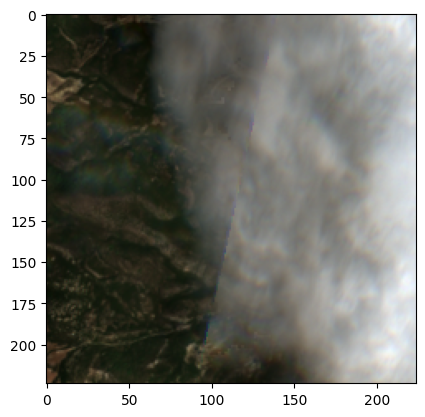

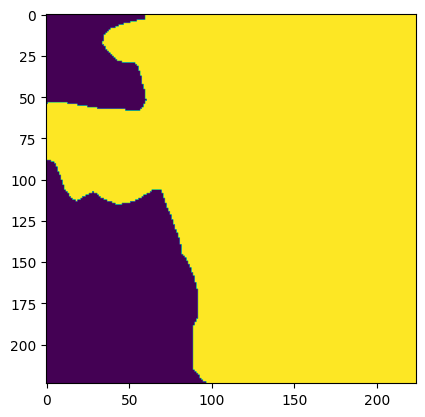

In [9]:
dataset_train_aug = TransformedDataset(dataset_train, transform_fn=transform_train)
dataset_eval_aug = TransformedDataset(dataset_eval, transform_fn=transform_eval)

# Exécuter les tests ici
#dataset_train.plot(2)
dataset_train_aug.plot(2)
#dataset_eval.plot(2)
item = dataset_train_aug[2]
item['image']


# Préparation de l'architecture du réseau

L'architecture d'un réseau de segmentation diffère de celle d'un réseau de classification. En particulier, en classification, un réseau retourne, pour chaque image mise en entrée, un vecteur de taille égale au nombre de classes alors que, pour la segmentation, on veut en sortie une matrice de taille *hauteur de l'entrée* x *largeur de l'entrée* x *nombre de classes*. On pourrait dire qu'on a un résultat de classification pour chaque pixel de l'entrée.

Il est donc évident qu'on ne peut pas utiliser un réseau qui réduit les dimensions spatiales et qui se termine pas des couches fully-connected. L'architecture de segmentation la plus classique est l'architecture U-Net. Le schéma suivant donne l'exemple de la première architecture U-Net proposée :

<img src="https://miro.medium.com/max/1200/1*f7YOaE4TWubwaFF7Z1fzNw.png" alt="drawing" width="600"/>

On remarque plusieurs caractéristiques :

- le réseau peut être découpé être en deux parties. La première est similaire à un réseau de classification et utilise des convolutions et des couches de pooling pour extraire des features et faire diminuer la résolution progressivement jusqu'à arriver une résolution divisée par 4. On appelle généralement cette partie l'encodeur. La deuxième partie se fait en miroir et enchaine des couches de convolution et de up-sampling pour faire reaugmenter la résolution jusqu'à la résolution de départ. On appelle cette partie le décodeur.
- des ponts, appelés *skip-connections*, relient les parties de même résolution dans l'encodeur et le décodeur. Elles servent à ne pas perdre l'information spatiale qui est en partie perdu dans le chemin principal à cause des diminutions de résolution.
- les couches notées ici "up-conv" sont spécifiques à la segmentation et servent à reaugmenter la résolution spatiale. Elles peuvent être implémentées de différentes manières, les plus classiques étant les couches d'interpolation et les couches de *transposed convolutions* qui s'écrivent sous forme de convolutions en utilisant une image avec un padding astucieux (voir lien suivant pour plus de détails [lien](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d))
- (on voit également que dans cette première proposition les auteurs avaient fait le choix de ne pas faire de padding et que les convolutions engendrent une diminution de la taille de l'image. On peut éviter ce problème en recourant à du padding.)

On peut représenter schématiquement un modèle U-Net générique comme ceci :

<img src="https://github.com/qubvel/segmentation_models/blob/master/images/unet.png?raw=true" alt="drawing" width="600"/>

On visualise alors très bien l'aspect général de l'architecture. Il est facile de comprendre des changements peuvent être facilement opérés en restant sur le même schéma. On peut par exemple faire varier le nombre de descente de résolution. Plus intéressant encore, la partie encodeur peut être remplacée par n'importe quelle architecture de classification à laquelle on aura retiré les dernières couches *fully-connected*. Cette pratique est très courante et permet à l'architecture de segmentation U-Net de bénéficier des dernières avancées introduites pour la classification.

La dernière remarque essentielle vis-à-vis de l'architecture U-Net est qu'elle est dite *fully convolutional* du fait qu'elle est essentiellement basée sur des couches de convolution et n'utilise pas de couches denses. La conséquence est que le réseau peut prendre en entrée des images de taille arbitraire et la taille de sortie s'adaptera automatiquement. Il faut tout de même s'assurer que la largeur et hauteur soit divisible par 2^(*nombre de descente de résolution*) afin d'éviter des problèmes au niveau des pooling et up-conv.

Sachant tout cela, définissons d'abord un encodeur que nous utiliserons après dans notre architecture U-Net.
On propose d'utiliser un encodeur simple proche des architectures de classification appelées VGG.

Exécuter les deux blocs de code suivant pour instancier cet encodeur.

**Analyser l'architecture de cet encodeur** :
- nombre de descente de résolution
- nombre de couches de convolutions et taille des filtres utilisés
- type d'activation
- nombre de paramètres
- expliquer la forme de la sortie de la méthode forward()

La function *summary()* fait l'essentiel du travail de cette analyse. **Retrouvez et expliquez le calcul qui a permis de donner le nombre de paramètres de la couche de convolution numérotée 2-5.**

NB: on remarquera que des couches appelées BatchNorm2d sont utilisées après les convolutions. On ne s'attardera pas dessus dans le cadre de ce TD mais elles opèrent une renormalisation en sortie des couches convolutions qui permet généralement d'accélérer la convergence du modèle lors de l'entrainement.


- nombre de descente de résolution \
-->5 descentes de résolution
- nombre de couches de convolutions et taille des filtres utilisés\
-->8 couches de convolutions toutes utilisant un filtre de taille 3x3
- type d'activation \
-->ReLU
- nombre de paramètres \
-->total : 9,226,560

explication couche 2-5 : \
Conv2d: 2-5 : [1, 128, 112, 112] : 73,856
taille filtre : (3x3x64) \
taille output : 128 \
(3x3x64) x 128 + 128 = 576 x 128 + 128 = 73 728 + 128 = 73 856


- expliquer la forme de la sortie de la méthode forward() \
la méthode forward() renvoie 'outs' qui est une liste des tenseurs issues des couches de convolution \
on aura d'abord x = [tenseur taille (224,224,64)] \
puis \
x = [tenseur taille (224,224,64), tenseur taille (112,112,128)] \
etc...

In [10]:
# Encoder definition
import torch.nn as nn
import torch.nn.functional as F

class VGG(nn.Module):
    def __init__(self, in_channels):
        super(VGG, self).__init__()
        self.in_channels = in_channels

        self.stage_1 = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.stage_2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.stage_3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.stage_4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        self.stage_5 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

    def forward(self, x):
        outs = []
        x = self.stage_1(x)
        outs.append(x)
        x = self.stage_2(x)
        outs.append(x)
        x = self.stage_3(x)
        outs.append(x)
        x = self.stage_4(x)
        outs.append(x)
        x = self.stage_5(x)
        outs.append(x)

        return outs

In [11]:
encoder = VGG(in_channels=4)
summary(encoder, input_size=(1, 4, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 64, 224, 224]         --
├─Sequential: 1-1                        [1, 64, 224, 224]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         2,368
│    └─BatchNorm2d: 2-2                  [1, 64, 224, 224]         128
│    └─ReLU: 2-3                         [1, 64, 224, 224]         --
├─Sequential: 1-2                        [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-5                       [1, 128, 112, 112]        73,856
│    └─BatchNorm2d: 2-6                  [1, 128, 112, 112]        256
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
├─Sequential: 1-3                        [1, 256, 56, 56]          --
│    └─MaxPool2d: 2-8                    [1, 128, 56, 56]          --
│    └─Conv2d: 2-9                       [1, 256, 56, 56]          295,168
│

Afin de finaliser l'architecture du modèle U-Net, il vous revient de finir d'écrire la méthode forward de la classe Unet() suivante.

Tous les différents blocs ont été définis dans le constructeur de la classe et ne nécessitent aucune modification.

Il suffit donc simplement d'enchainer correctement les *up_conv* et les *double_conv* en se basant sur le schéma du U-Net présenté plus haut.

La mise en place des skip-connections se fera à l'aide de la fonction [torch.cat()](https://pytorch.org/docs/stable/generated/torch.cat.html).

In [13]:
# Decoder definition
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def up_conv(in_channels, out_channels):
    return nn.ConvTranspose2d(
        in_channels, out_channels, kernel_size=2, stride=2
    )

class Unet(nn.Module):
    def __init__(self, encoder, in_channels=3, out_channels=2):
        super().__init__()

        self.encoder = encoder

        self.up_conv1 = up_conv(512, 512)
        self.double_conv1 = double_conv(1024, 512)
        self.up_conv2 = up_conv(512, 256)
        self.double_conv2 = double_conv(512, 256)
        self.up_conv3 = up_conv(256, 128)
        self.double_conv3 = double_conv(256, 128)
        self.up_conv4 = up_conv(128, 64)
        self.double_conv4 = double_conv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        input_ = x
        blocks = self.encoder(x)
        #print(blocks)

        # utiliser les sorties de l'encoder, analysées dans la question précédante pour compléter l'architecture U-Net
        ###########################
        x = self.up_conv1(blocks[-1])
        x = torch.cat((blocks[-2],x),1)
        x = self.double_conv1(x)
        
        x = self.up_conv2(x)
        x = torch.cat((blocks[-3],x),1)
        x = self.double_conv2(x)
        
        x = self.up_conv3(x)
        x = torch.cat((blocks[-4],x),1)
        x = self.double_conv3(x)
        
        x = self.up_conv4(x)
        x = torch.cat((blocks[-5],x),1)
        x = self.double_conv4(x)


        ###########################

        x = self.final_conv(x)

        return x

In [14]:
model = Unet(encoder, in_channels=4, out_channels=2)
model.to(device)
summary(model, input_size=(1, 4, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Unet                                     [1, 2, 224, 224]          --
├─VGG: 1-1                               [1, 64, 224, 224]         --
│    └─Sequential: 2-1                   [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-1                  [1, 64, 224, 224]         2,368
│    │    └─BatchNorm2d: 3-2             [1, 64, 224, 224]         128
│    │    └─ReLU: 3-3                    [1, 64, 224, 224]         --
│    └─Sequential: 2-2                   [1, 128, 112, 112]        --
│    │    └─MaxPool2d: 3-4               [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-5                  [1, 128, 112, 112]        73,856
│    │    └─BatchNorm2d: 3-6             [1, 128, 112, 112]        256
│    │    └─ReLU: 3-7                    [1, 128, 112, 112]        --
│    └─Sequential: 2-3                   [1, 256, 56, 56]          --
│    │    └─MaxPool2d: 3-8               [1, 128, 56, 56]          --
│    │

# Paramétrer l'apprentissage

Pour reprendre les explications données au début du TD, on doit maintenant se pencher sur les hyperparamètres, c'est-à-dire les paramètres du processus d'apprentissage.

Pour avancer plus rapidement jusqu'à l'apprentissage, le blocs suivant définit déjà plusieurs éléments nécessaires : la fonction de coût, l'algorithme d'optimisation et le mécanisme de création des batchs d'images.

Après avoir rapidement pris connaissance du code, on peut poursuivre pour se pencher sur la définition des métriques de performance.

In [15]:
# setup loss
loss_fn = nn.CrossEntropyLoss().to(device=device)

# setup optimizer
optimizer = torch.optim.Adam(model.parameters())

# setup torch dataloader
train_batch_size = 16
eval_batch_size = 16

dataloader_train = torch.utils.data.DataLoader(
    dataset_train_aug,
    shuffle=True,
    batch_size=train_batch_size,
    num_workers=2,
    drop_last=True,
    pin_memory=True
)
dataloader_eval = torch.utils.data.DataLoader(
    dataset_eval_aug,
    shuffle=False,
    batch_size=eval_batch_size,
    num_workers=2,
    drop_last=False,
    pin_memory=True
)

On souhaite maintenant préparer les métriques qui nous permettrons d'évaluer les résultats.

Pour cela, un des outils de base les plus utilisés est la matrice de confusion. Cette matrice est une matrice carré de taille CxC où C est le nombre de classe du problème considéré. Si on note $M$ cette matrice, l'élément $M_{i,j}$ correspond au nombre d'éléments de la classe i qui ont été prédits comme appartenant à la classe j. On rappelle que, dans le cas d'un problème de segmentation, on préduit une classe pour chaque pixel donc la somme de toutes les coefficients de la matrice de confusion correspond au nombre de pixels évalués.

Dans le cas d'une classification parfaite, seul les éléments diagonaux de la matrice de confusion sont non nuls.

**On cherche maintenant à créer une classe ConfusionMatrix qui nous permettra d'évaluer le réseau. Commencez par compléter ci-dessous la méthode update() qui doit permettre de mettre à jour la matrice de confusion.**

Pour une classe i donnée, on parle de :
- vrais positifs pour les éléments bien classifiés ($M_{i,i}$)
- faux négatifs pour les éléments de la classe i classifiés comme une autre classe ($\sum_{j,j\neq i} M_{i,j}$)
- faux positifs pour les éléments n'appartenant pas à la classe i mais classifié comme tel ($\sum_{j,j\neq i} M_{j,i}$)

Il est possible de regarder ces différents éléments pour évaluer les performances mais, en général, on calcule des métriques plus globales à partir de ces éléments. Les métriques les plus classiques sont le  rappel et la précision qui sont définies de la façon suivante :
- *précision* : la précision associée à une classe correspond au pourcentage d'éléments prédits comme appartenant à cette classe qui appartiennent vraiment à celle-ci. Autrement dit, il s'agit du nombre de vrais positifs divisé par la somme des vrais positifs plus faux positifs. Dans l'exemple que nous traitons, la précision de la classe 'nuage' donne le pourcentage des pixels que j'ai prédit comme des nuages qui sont vraiment des nuages.
- *rappel* : le rappel associé à une classe correspond au pourcentage d'éléments de la classe qui ont bien été prédits comme appartenant à cette classe. Autrement dit, il s'agit du nombre de vrais positiffs divisé par la somme des vrais positifs plus faux négatifs. Dans l'exemple que nous traitons, le rappel de la classe 'nuage' donne le pourcentage des pixels de nuage que j'ai bien prédit comme nuage.

**Complétez la méthode compute_metrics pour calculer le rappel et la précision à partir de la matrice de confusion**

NB: la classe ConfusionMatrix est très générique et peut être utilisée quel que soit le nombre de classe. Si vous éprouvez quelques difficultés, vous pouvez la particulariser pour deux classes.

In [184]:
class ConfusionMatrix():
    def __init__(self, nb_class):
        self.nb_class = nb_class
        self.confusion_matrix = np.zeros((self.nb_class, self.nb_class))
        
    def reset(self):
        self.confusion_matrix = np.zeros((self.nb_class, self.nb_class))
        
    def update(self, prediction, ground_truth):
        
        prediction = prediction.ravel()
        ground_truth = ground_truth.ravel()
        
        # Cette méthode sert à mettre à jour la matrice de confusion
        # à partir d'une prédiction faite par le réseau de neurones et
        # de la vérité terrain, c'est-à-dire ce qui est considéré comme la vérité
        ##################################
        for i in range(len(prediction)):
            self.confusion_matrix[ground_truth[i],prediction[i]] += 1

        ##################################
        
    def compute_metrics(self, class_i):
        
        # cette méthode est appelée pour calculer des métriques associées à la classe i
        # à partir de la matrice de confusion
        ##################################
        # Rappel : 1=nuage, 0=sol
        TP = self.confusion_matrix[1,1] # Vrai positif
        FP = self.confusion_matrix[0,1] # Faux positifs
        TN = self.confusion_matrix[0,0] # Vrai négatifs
        FN = self.confusion_matrix[1,0] # Faux négatifs
        
        if (TP + FP) != 0:
            precision = TP/(TP + FP)
        else:
            precision = 0.0
        
        if (TP + FN) != 0:
            rappel = TP/(TP + FN)
        else:
            rappel = 0.0

        ##################################
        
        return rappel, precision

# Entrainement du réseau

Passons enfin à l'entrainement à proprement parler du réseau.

**Commençons par compléter la boucle d'apprentissage** dans le bloc suivant en ajoutant les étapes de forward, de backward et d'optimisation de la boucle d'entrainement (si ce n'est pas encore maitrisé, on pourra se référer au TD d'introduction à Pytorch comme exemple).


In [27]:
nb_epoch = 5

# dans un entraînement normal, on voit chaque élément une fois dans une époque
# pour ne pas prendre trop de temps, nous fixons un nombre de batch vu pour chaque époque
nb_batch_per_epoch = 20

In [28]:
# reset model
encoder = VGG(in_channels=4)
model = Unet(encoder, in_channels=4, out_channels=2)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# time execution
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()

# instance confusion matrix
cm_train = ConfusionMatrix(2)

# define lists used to store loss and metrics at each epoch
loss_historic = []
rappel_historic = []
precision_historic = []

# main training loop
for epoch in range(nb_epoch):
    
    # training step
    model.train()
    running_loss = 0.0
    batch_count = 0
    for bx, batch in enumerate(dataloader_train):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #######################
        inputs, label_data = batch['image'].to(device), batch['mask'].to(device).long()
        #print(f"inputs : {inputs.shape}, {inputs.dtype}")
        #print(f"labels : {label_data.shape}, {label_data.dtype}")
        
        prediction = model(inputs)
        #print(f"outputs : {prediction.shape}, {prediction.dtype}")
        #outputs = outputs.long()
        
        loss = loss_fn(prediction, label_data)
        loss.backward()
        
        optimizer.step()
        #######################

        running_loss += loss.item()

        # update confusion matrix
        class_prediction = torch.argmax(prediction.cpu().detach(), axis=1)
        cm_train.update(class_prediction, label_data.cpu().detach())

        batch_count += 1
        print(f"Batch {bx+1}/{nb_batch_per_epoch}: [LOSS] {running_loss/batch_count:.4f}")
        
        if batch_count==nb_batch_per_epoch:
            break
            
    epoch_loss = running_loss/batch_count
    rappel, precision = cm_train.compute_metrics(1)
    print(f'Training: [EPOCH] {epoch+1}/{nb_epoch} => [LOSS] {epoch_loss:.4f}, [RAPPEL] {rappel:.4f}, [PRECISION] {precision:.4f}')
    print('-----------------------------------------------')

    loss_historic.append(epoch_loss)
    rappel_historic.append(rappel)
    precision_historic.append(precision)
    cm_train.reset()

    torch.save(model.state_dict(), './model_last_ep{}.pt'.format(epoch))
    
end.record()
torch.cuda.synchronize()  # Waits for everything to finish running on the GPU
print(f"GPU time: {0.001/60 * start.elapsed_time(end):6.5f}min")  # Milliseconds to minutes

Batch 1/20: [LOSS] 0.7593
Batch 2/20: [LOSS] 0.6578
Batch 3/20: [LOSS] 0.6695
Batch 4/20: [LOSS] 0.6346
Batch 5/20: [LOSS] 0.5833
Batch 6/20: [LOSS] 0.5626
Batch 7/20: [LOSS] 0.5509
Batch 8/20: [LOSS] 0.5360
Batch 9/20: [LOSS] 0.5255
Batch 10/20: [LOSS] 0.5378
Batch 11/20: [LOSS] 0.5325
Batch 12/20: [LOSS] 0.5156
Batch 13/20: [LOSS] 0.5059
Batch 14/20: [LOSS] 0.5080
Batch 15/20: [LOSS] 0.5014
Batch 16/20: [LOSS] 0.4986
Batch 17/20: [LOSS] 0.5015
Batch 18/20: [LOSS] 0.4973
Batch 19/20: [LOSS] 0.4905
Batch 20/20: [LOSS] 0.4916
Training: [EPOCH] 1/5 => [LOSS] 0.4916, [RAPPEL] 0.7316, [PRECISION] 0.8796
-----------------------------------------------
Batch 1/20: [LOSS] 0.3818
Batch 2/20: [LOSS] 0.4343
Batch 3/20: [LOSS] 0.4319
Batch 4/20: [LOSS] 0.4198
Batch 5/20: [LOSS] 0.4091
Batch 6/20: [LOSS] 0.4203
Batch 7/20: [LOSS] 0.4029
Batch 8/20: [LOSS] 0.4036
Batch 9/20: [LOSS] 0.4069
Batch 10/20: [LOSS] 0.3946
Batch 11/20: [LOSS] 0.4020
Batch 12/20: [LOSS] 0.4038
Batch 13/20: [LOSS] 0.4081
Bat

**Répondez aux questions suivantes :**
- Pourquoi la loss ne décroit-elle pas strictement ? \
Peut être que la loss tombe dans des minimums locaux. Il est aussi possible que le learning rate ne soit pas adapté.
- Pourquoi les scores de précision et de rappel varie-t-il autant entre chaque époque? \
Training: [EPOCH] 1/5 => [LOSS] 0.4916, [RAPPEL] 0.7316, [PRECISION] 0.8796 \
Training: [EPOCH] 2/5 => [LOSS] 0.4047, [RAPPEL] 0.7857, [PRECISION] 0.9070 \
Training: [EPOCH] 3/5 => [LOSS] 0.4128, [RAPPEL] 0.8268, [PRECISION] 0.8812 \
Training: [EPOCH] 4/5 => [LOSS] 0.3690, [RAPPEL] 0.8138, [PRECISION] 0.8917 \
Training: [EPOCH] 5/5 => [LOSS] 0.3526, [RAPPEL] 0.8295, [PRECISION] 0.8872 \

Les scores de précision et de rappel varient autant entre chaque époques parce que en changeant les paramètres du modèle (les poids des filtres), on améliore globalement le modèle mais certaines métriques peuvent diminuer un petit peu. 

- Citez plusieurs possibilités pour améliorer les performances d'apprentissage \
On peut entraîner le modèle sur tout le set de données (et non pas seulement 20 batchs). \
On peut aussi entraîner le modèle sur plus de 5 époques pour lui laisser plus de temps pour converger.

# Evaluation du réseau

Compléter le code suivant pour afficher quelques images avec leur masque de vérité terrain et leur prédiction. On pourra s'inspirer de la méthode plot() de classe CloudDataset définie dans la première partie du TD.

Analyser les limites des masques de prédictions.

In [160]:
import cv2 as cv

def plot(img, pred, gt):
        #sample = self.__getitem__(idx)

        #img = sample["image"][:,:,:3].astype("float32")

        # Constrast enhancement for better visualisation
        img = (img - np.amin(img))/(np.amax(img) - np.amin(img))
        
        #On seuil à 0.5
        ret,thresh1 = cv.threshold(pred,0.5,1.0,cv.THRESH_BINARY)
        
        print(f"mean prediction : {np.mean(pred):.3} / pred_threshold : {np.mean(thresh1):.3}")
        #print(f"{np.unique(thresh1)} / {np.max(thresh1)} / {np.min(thresh1)}")
        #print(thresh1[150:170,150:170])
        
        # Plots
        #fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))
        ax1.imshow(img[:,:,::-1])
        ax1.grid(False)
        ax1.set_title('image')
        
        ax2.imshow(pred, vmin=0, vmax=1)
        ax2.grid(False)
        ax2.set_title('prediction')
        
        ax3.imshow(thresh1, vmin=0, vmax=1)
        ax3.grid(False)
        ax3.set_title('pred_threshold (0.5)')
        
        ax4.imshow(gt, vmin=0, vmax=1)
        ax4.grid(False)
        ax4.set_title('ground_truth')
        
        plt.show()
        
        
        

mean prediction : 0.528 / pred_threshold : 0.903


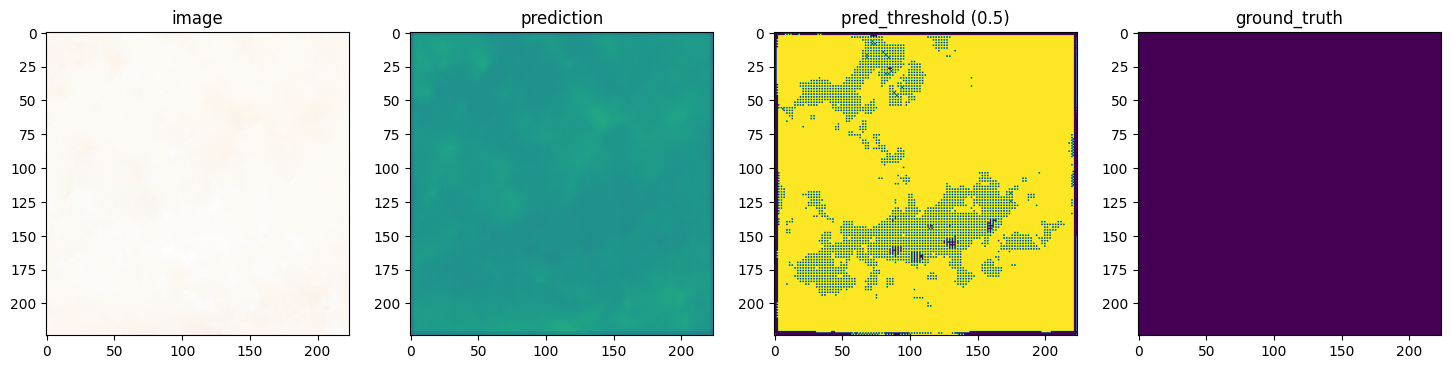

mean prediction : 0.989 / pred_threshold : 1.0


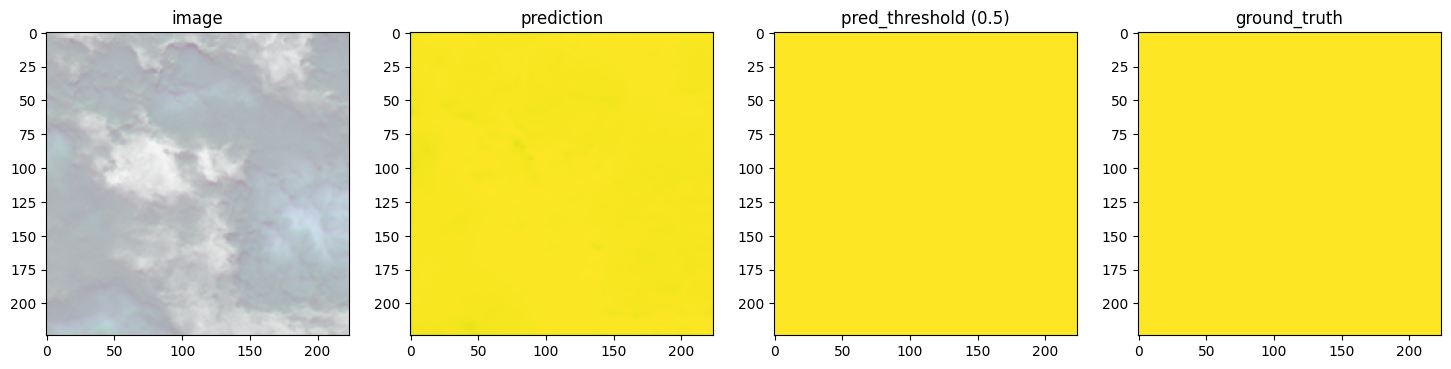

mean prediction : 0.683 / pred_threshold : 0.673


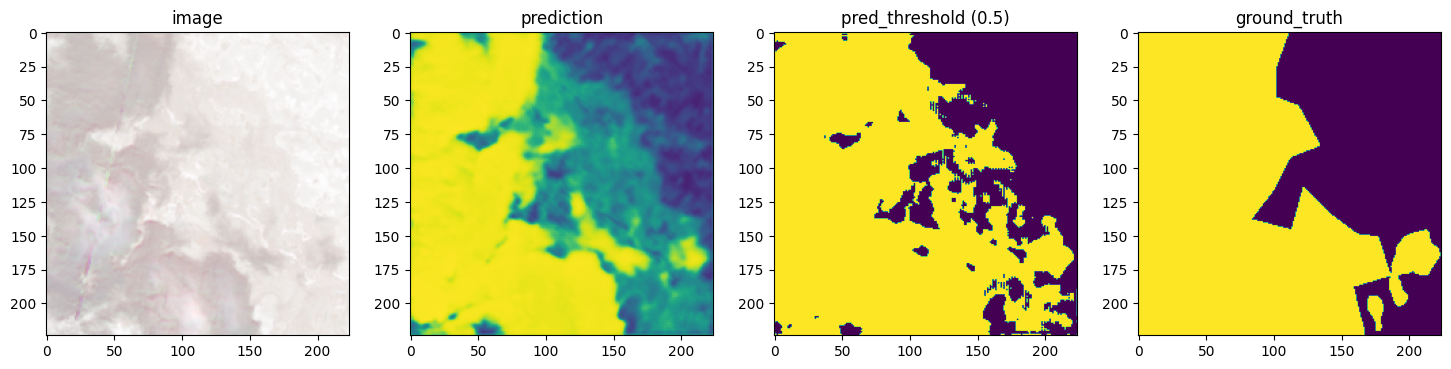

mean prediction : 0.573 / pred_threshold : 0.494


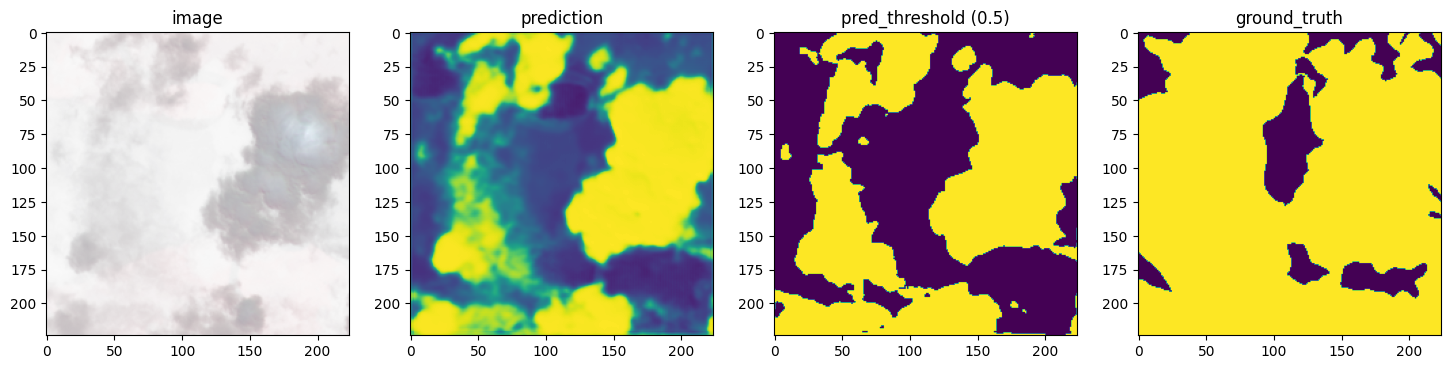

mean prediction : 0.991 / pred_threshold : 1.0


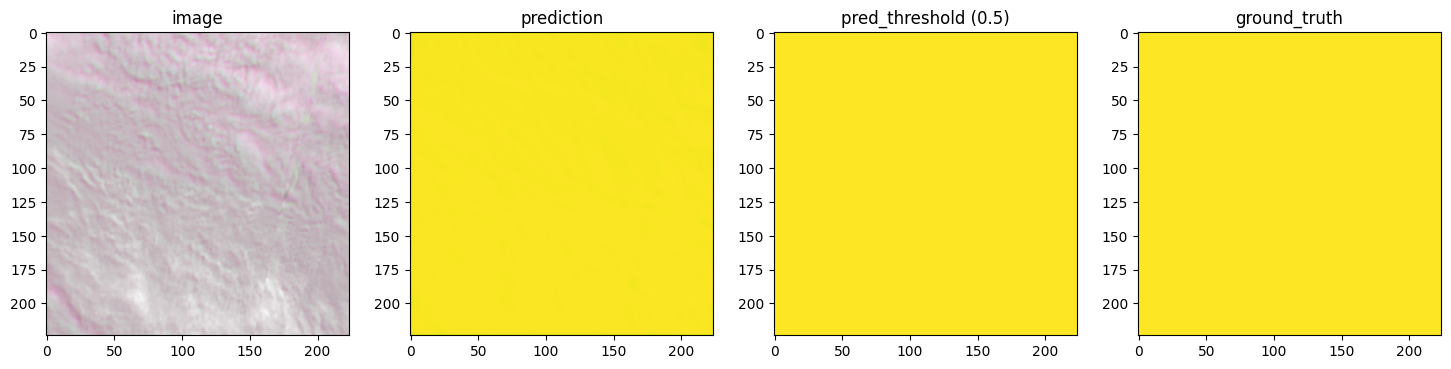

mean prediction : 0.75 / pred_threshold : 0.863


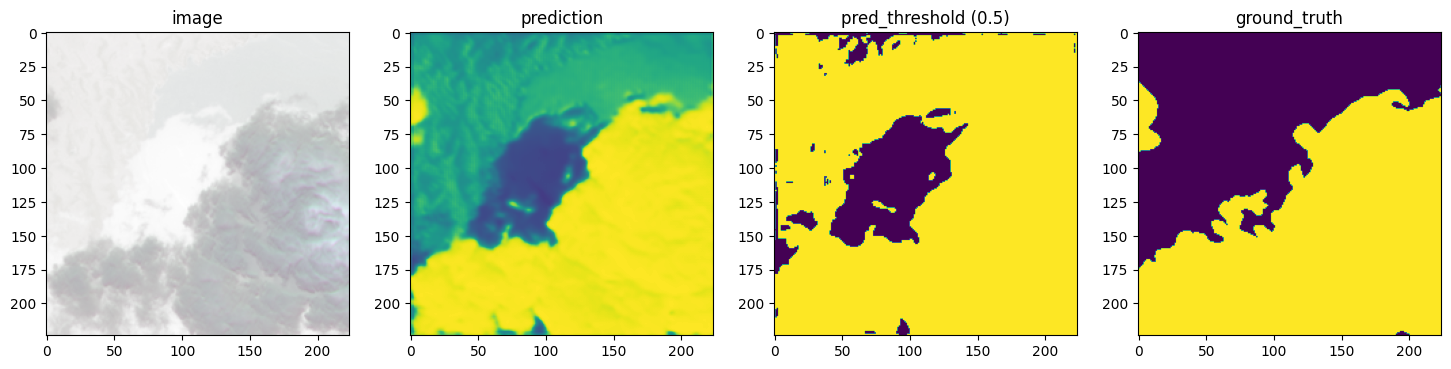

mean prediction : 0.929 / pred_threshold : 0.937


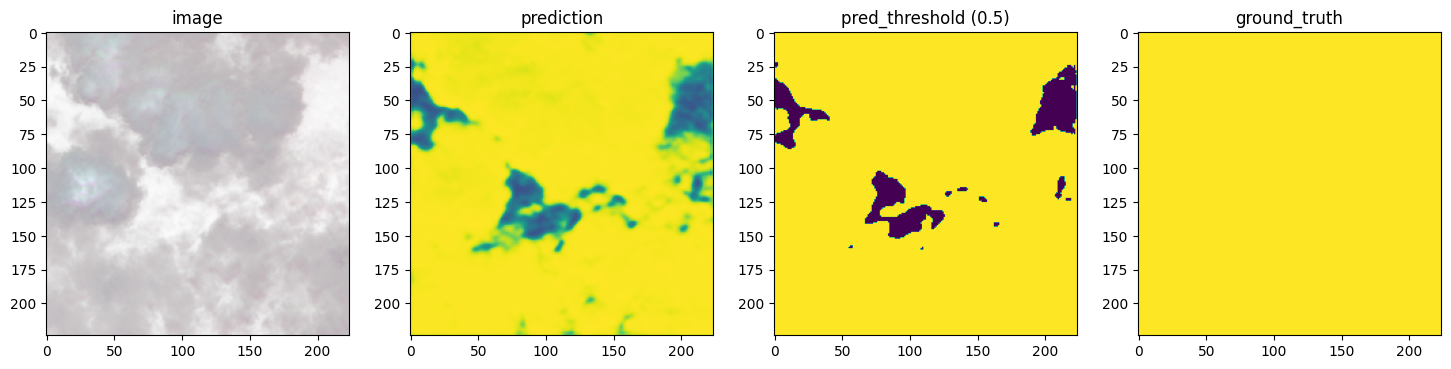

mean prediction : 0.297 / pred_threshold : 0.185


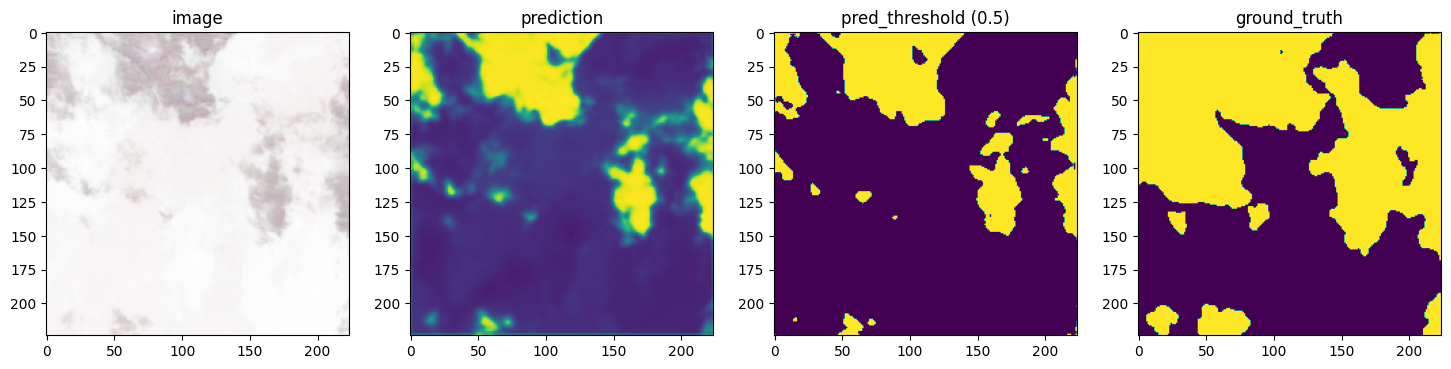

mean prediction : 0.814 / pred_threshold : 0.796


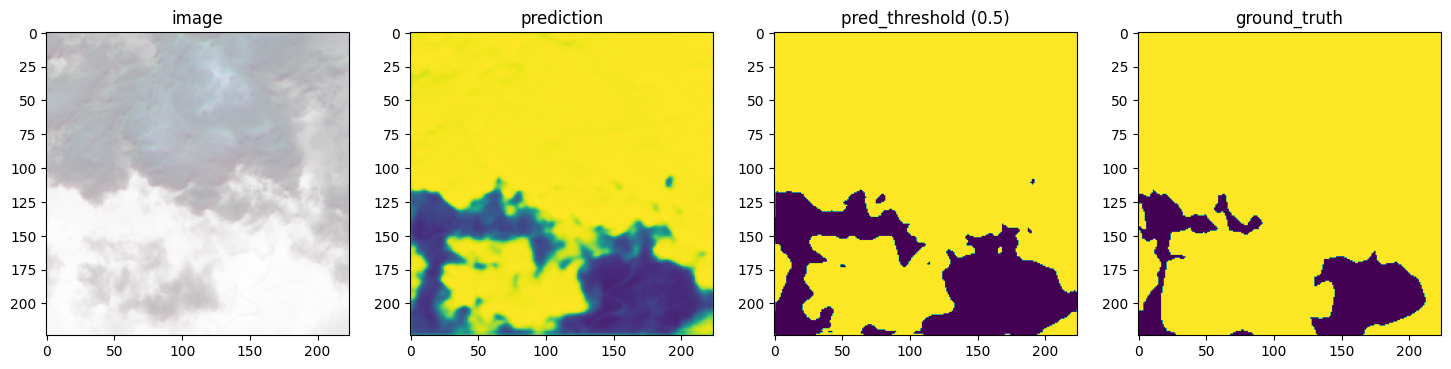

mean prediction : 0.661 / pred_threshold : 0.604


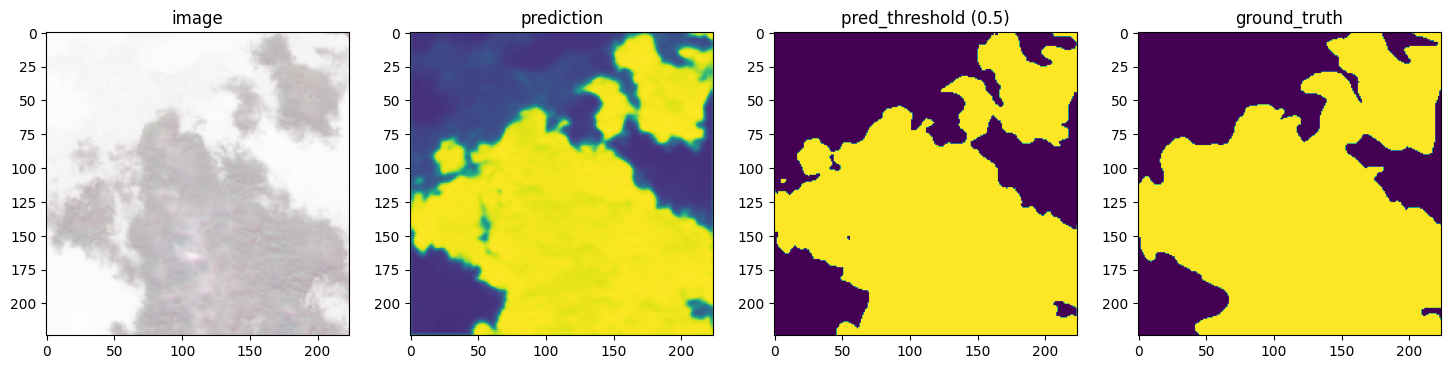

In [161]:
model.eval()
nb_plot = 10 # nombre d'exemple à afficher
with torch.no_grad():
    plot_count = 0
    for bx, batch in enumerate(dataloader_eval):

        input_data, label_data = batch["image"], batch["mask"].numpy()
        output_data = torch.softmax(model(input_data.to(device)), dim=1).cpu().detach().numpy()

        img_batch = np.transpose(input_data.detach().numpy(), (0,2,3,1))
        #label_batch = np.transpose(input_data.detach().numpy(), (0,2,3,1))

        for img_index in range(img_batch.shape[0]):

            # Ecrire ici le nécessaire pour afficher les images et masques
            ######################

            #print(img_batch[img_index].shape)
            #print(output_data[img_index,0].shape)

            #plot(img_batch[img_index],output_data[img_index,0])
            plot(img_batch[img_index],output_data[img_index,1],label_data[img_index]) # classe nuage
            #print(np.max(output_data[img_index,1]))
            #print(np.min(output_data[img_index,1]))
            #print(np.mean(output_data[img_index,1]))
            #print()
            #print(output_data[img_index,1])
            #print(output_data[img_index,1,1])


            ######################

            plot_count += 1

            if plot_count>=nb_plot:
                break

        if (bx+1)*eval_batch_size>=nb_plot:
            break


**Analyser les limites des masques de prédictions. Sont-ils bons ? Ont-ils un défaut particulier ? En quoi diffèrent-t-ils de la vérité terrain ?**

Ci-dessus nous affichons, dans l'ordre, l'image (R,G,B), la prédiction de notre modèle (valeurs de 0 à 1), la prédiction mais seuillée à 0.5 (valeurs 0 ou 1) et enfin le ground_truth.

Dans le 1er cas où tout le ground_truth est à 0, notre modèle a une prédiction assez homogène en moyenne à 0.528, ce qui donne en prediction seuillée une mauvaise prediction.
On remarque aussi des effets de grille.

Dans les cas où tout le ground_truth est à 1, notre modèle est plutôt très bon.

Dans les autres cas, notre modèle est plutôt bon, et reproduit assez fidèlement les formes observées sur le ground_truth tout en faisant quelques erreurs locales.

On remarque que nos masques reproduisent assez bien les masques de ground_truth quand ceux-ci ont été fait avec du détail sur les contours.

On remarque aussi que l'on a tendance à retrouver sur nos masques des formes qui apparaissent sur l'image mais qui ne sont pas des nuages d'après le ground_truth. 

**En reprenant le code précédent et en s'inspirant du code d'entrainement, calculer les métriques de précision et de rappel sur l'ensemble d'évaluation.**

In [250]:
model.eval()

# instance confusion matrix
cm_train = ConfusionMatrix(2)

debug = False
nb_batch = 5 # nombre d'exemple à afficher
    
with torch.no_grad():
    plot_count = 0
    for bx, batch in enumerate(dataloader_eval):

        input_data, label_data = batch["image"], batch["mask"].numpy()
        output_data = torch.softmax(model(input_data.to(device)), dim=1).cpu().detach().numpy()

        img_batch = np.transpose(input_data.detach().numpy(), (0,2,3,1))

        for img_index in range(img_batch.shape[0]):

            # Ecrire ici le nécessaire pour afficher les métriques
            ######################
            ret,thresh1 = cv.threshold(output_data[img_index,1],0.5,1.0,cv.THRESH_BINARY)

            cm_train.update(thresh1.astype(int), label_data[img_index].astype(int))
            
            
            
            ######################

            plot_count += 1

            if (plot_count>=nb_plot) & debug:
                break

        if ((bx+1)*eval_batch_size>=nb_plot) & debug:
            break

rappel, precision = cm_train.compute_metrics(1)

print("Métriques sur tout le dataset d'évaluation:")
print(f"Nombre d'images : {plot_count}")
print(f"rappel : {rappel:.2}")
print(f"precision : {precision:.2}")

cm_train.reset()

Métriques sur tout le dataset d'évaluation:
Nombre d'images : 470
rappel : 0.8
precision : 0.92


Chargez maintenant un modèle entrainé sur beaucoup plus d'époques à l'aide du code ci-dessous et évaluez-le.


In [191]:
# load model
model_long_training = Unet(VGG(in_channels=4), in_channels=4, out_channels=2)
model_long_training.load_state_dict(torch.load('./model_long_training.pt'))
model_long_training.to(device)

Unet(
  (encoder): VGG(
    (stage_1): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (stage_2): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (stage_3): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, trac

In [251]:
# faites l'évaluation de ce modèle ici
model_long_training.eval()

# instance confusion matrix
cm_train = ConfusionMatrix(2)

debug = False
nb_batch = 5 # nombre d'exemple à afficher
    
with torch.no_grad():
    plot_count = 0
    for bx, batch in enumerate(dataloader_eval):

        input_data, label_data = batch["image"], batch["mask"].numpy()
        output_data = torch.softmax(model_long_training(input_data.to(device)), dim=1).cpu().detach().numpy()

        img_batch = np.transpose(input_data.detach().numpy(), (0,2,3,1))

        for img_index in range(img_batch.shape[0]):

            # Ecrire ici le nécessaire pour afficher les métriques
            ######################
            ret,thresh1 = cv.threshold(output_data[img_index,1],0.5,1.0,cv.THRESH_BINARY)

            cm_train.update(thresh1.astype(int), label_data[img_index].astype(int))
            
            if debug:
                plot(img_batch[img_index],output_data[img_index,1],label_data[img_index]) # classe nuage
            
            ######################

            plot_count += 1

            if (plot_count>=nb_plot) & debug:
                break

        if ((bx+1)*eval_batch_size>=nb_plot) & debug:
            break

rappel, precision = cm_train.compute_metrics(1)

print("Métriques sur tout le dataset d'évaluation:")
print(f"Nombre d'images : {plot_count}")
print(f"rappel : {rappel:.2}")
print(f"precision : {precision:.2}")

cm_train.reset()

Métriques sur tout le dataset d'évaluation:
Nombre d'images : 470
rappel : 0.075
precision : 0.99


**Comparez ces résultats avec votre modèle.**

Notre modèle entrainé sur 5 époques : \
rappel : 0.8\
precision : 0.92

Le modèle entraîné pendant très longtemps : \
rappel : 0.075\
precision : 0.99

Une précision proche de 1.0 veut dire que le modèle, quand il classifie un pixel comme nuage, ne se trompe presque pas.\
Un rappel proche de 0.0 veut dire que le modèle classifie une très petite quantitée des pixels comme nuage sur tout ceux qui devraient l'être.

Notre modèle est plutôt bon avec un rappel de 0.8 et une précision de 0.92.

En revanche, même si le modèle longtemps entraîné est très précis (précision à 0.99), son score de rappel est très faible (0.075). Ce modèle oublie pleins de pixels de nuage mais quand il classifie un pixel comme nuage, il a très souvent raison. Notre interprétation est que ce modèle est surentraîné. 

(question bonus) **Trouver les 5 images avec le rappel le plus faible et les 5 images avec la précision la plus faible.**

In [267]:
# faites l'évaluation de ce modèle ici
model_long_training.eval()

# instance confusion matrix
cm_train = ConfusionMatrix(2)

nb_plot = 50
debug = False
nb_batch = 5 # nombre d'exemple à afficher

count_zero = True

# define lists used to store loss and metrics at each epoch
rappel_historic = []
precision_historic = []
    
with torch.no_grad():
    plot_count = 0
    for bx, batch in enumerate(dataloader_eval):

        input_data, label_data = batch["image"], batch["mask"].numpy()
        output_data = torch.softmax(model_long_training(input_data.to(device)), dim=1).cpu().detach().numpy()

        img_batch = np.transpose(input_data.detach().numpy(), (0,2,3,1))

        for img_index in range(img_batch.shape[0]):

            # Ecrire ici le nécessaire pour afficher les métriques
            ######################
            ret,thresh1 = cv.threshold(output_data[img_index,1],0.5,1.0,cv.THRESH_BINARY)

            cm_train.update(thresh1.astype(int), label_data[img_index].astype(int))
            
            rappel, precision = cm_train.compute_metrics(1)

            #print("Métriques sur tout le dataset d'évaluation:")
            #print(f"Image n° : {bx}")
            #print(f"rappel : {rappel:}")
            #print(f"precision : {precision:}")
            
            rappel_historic.append(rappel)
            precision_historic.append(precision)

            cm_train.reset()
            ######################

            plot_count += 1

            if (plot_count>=nb_plot) & debug:
                break

        if ((bx+1)*eval_batch_size>=nb_plot) & debug:
            break


def count_lowest(rappel_historic,nb_rappel,precision_historic,nb_precision,count_zero):
    # find the lowest values
    rappel_lowest_arg = []
    rappel_lowest_val = []
    precision_lowest_arg = []
    precision_lowest_val = []
    
    count_rappel = 0
    count_precision = 0
    
    rappel_historic_ = np.copy(rappel_historic)
    precision_historic_ = np.copy(precision_historic)
    
    for i in range(len(rappel_historic)):
        #rappel
        arg = np.argmin(rappel_historic_)
        val = rappel_historic[arg]

        if not(count_zero):
            if val > 0.0:
                rappel_lowest_arg.append(arg)
                rappel_lowest_val.append(val)
                count_rappel += 1
        else:
            rappel_lowest_arg.append(arg)
            rappel_lowest_val.append(val)
            count_rappel += 1

        rappel_historic_[arg] = 1.0
        if count_rappel>nb_rappel:
            break

    for i in range(len(rappel_historic)):
        #precision
        arg = np.argmin(precision_historic_)
        val = precision_historic[arg]

        if not(count_zero):
            if val > 0.0:
                precision_lowest_arg.append(arg)
                precision_lowest_val.append(val)
                count_precision += 1
        else:
            precision_lowest_arg.append(arg)
            precision_lowest_val.append(val)
            count_precision += 1

        precision_historic_[arg] = 1.0
        if count_precision>nb_precision:
            break
        
    return rappel_lowest_arg, rappel_lowest_val, precision_lowest_arg, precision_lowest_val

nb_rappel = 5
nb_precision = 5
count_zero = True

rappel_lowest_arg_0, rappel_lowest_val_0, precision_lowest_arg_0, precision_lowest_val_0 = count_lowest(rappel_historic,nb_rappel,precision_historic,nb_precision,count_zero)

print("En comptant les 0")
print(f"Nombre d'images : {len(rappel_historic)}")
print("Rappel : ")
print(rappel_lowest_arg_0)
print(rappel_lowest_val_0)
print()
print("Precision : ")
print(precision_lowest_arg_0)
print(precision_lowest_val_0)
print()

nb_rappel = 5
nb_precision = 5
count_zero = False

rappel_lowest_arg, rappel_lowest_val, precision_lowest_arg, precision_lowest_val = count_lowest(rappel_historic,nb_rappel,precision_historic,nb_precision,count_zero)

print("Sans compter les 0")
print(f"Nombre d'images : {len(rappel_historic)}")
print("Rappel : ")
print(rappel_lowest_arg)
print(rappel_lowest_val)
print()
print("Precision : ")
print(precision_lowest_arg)
print(precision_lowest_val)
print()





En comptant les 0
Nombre d'images : 470
Rappel : 
[0, 10, 12, 14, 19, 27]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Precision : 
[0, 10, 12, 14, 19, 27]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Sans compter les 0
Nombre d'images : 470
Rappel : 
[52, 92, 95, 202, 294, 309]
[1.992984693877551e-05, 1.992984693877551e-05, 1.992984693877551e-05, 1.992984693877551e-05, 1.992984693877551e-05, 1.992984693877551e-05]

Precision : 
[408, 280, 423, 302, 222, 38]
[0.012033694344163659, 0.5, 0.5, 0.9285714285714286, 0.9591836734693877, 0.975]



position : 52
rappel : 1.992984693877551e-05
mean prediction : 0.104 / pred_threshold : 0.000638


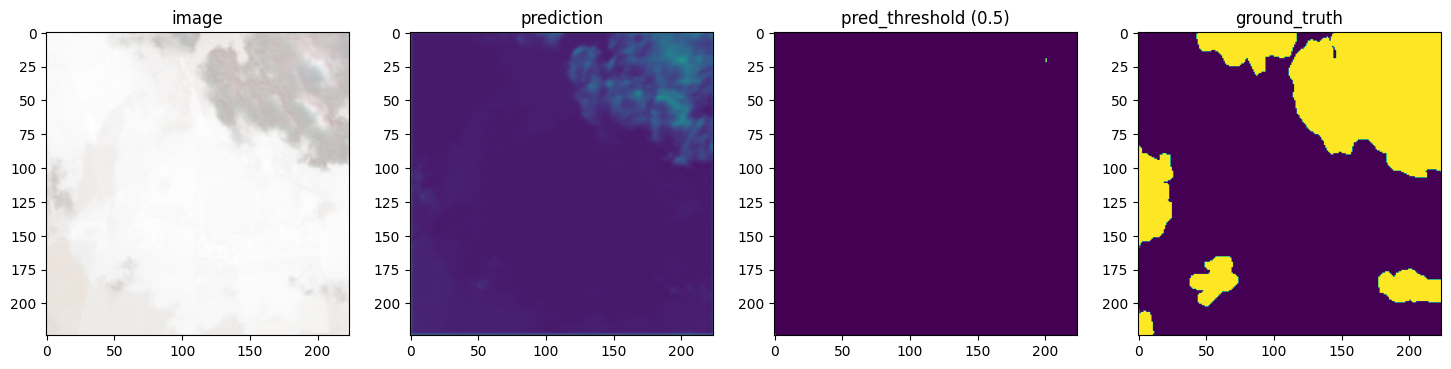

position : 92
rappel : 1.992984693877551e-05
mean prediction : 0.141 / pred_threshold : 0.0203


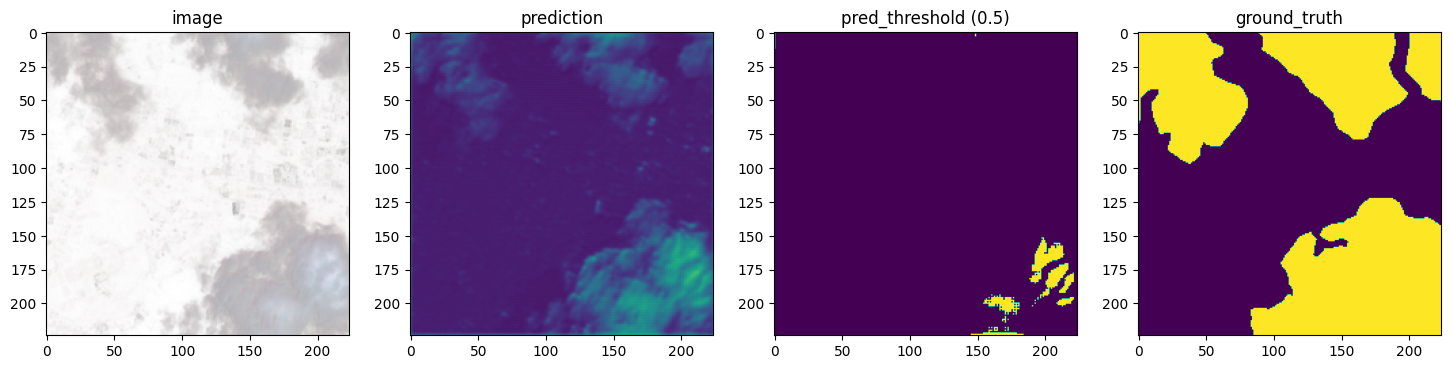

In [268]:
debug = False
# Plot les 5 images les moins bonnes en précision et rappel (sans compter les 0)

with torch.no_grad():
    plot_count_r = 0
    plot_count_p = 0
    
    for bx, batch in enumerate(dataloader_eval):

        input_data, label_data = batch["image"], batch["mask"].numpy()
        output_data = torch.softmax(model_long_training(input_data.to(device)), dim=1).cpu().detach().numpy()

        img_batch = np.transpose(input_data.detach().numpy(), (0,2,3,1))

        for img_index in range(img_batch.shape[0]):

            # Ecrire ici le nécessaire pour plot les 5 images avec les moins bonnes métriques
            ######################
            # Sans compter les 0
            # rappel
            if (img_index*bx == rappel_lowest_arg[plot_count_r]) & (plot_count_r<5):
                print(f"position : {rappel_lowest_arg[plot_count_r]}")
                print(f"rappel : {rappel_lowest_val[plot_count_r]}")
                plot(img_batch[img_index],output_data[img_index,1],label_data[img_index]) # classe nuage
                plot_count_r += 1
            
            #precision
            if (img_index*bx == precision_lowest_arg[plot_count_p]) & (plot_count_p<5):
                plot(img_batch[img_index],output_data[img_index,1],label_data[img_index]) # classe nuage
                plot_count_p += 1
                
            ######################

            

            if (plot_count_r>=nb_plot) & (plot_count_p>=nb_plot):
                break

        if ((bx+1)*eval_batch_size>=nb_plot) & debug:
            break

Sur le modèle entraîné pendant longtemps : 

En comptant les 0\
Nombre d'images : 470\
Rappel : \
[0, 10, 12, 14, 19, 27]\
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Precision : \
[0, 10, 12, 14, 19, 27]\
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]



Sans compter les 0\
Nombre d'images : 470\
Rappel : \
[52, 92, 95, 202, 294, 309]\
[1.992984693877551e-05, 1.992984693877551e-05, 1.992984693877551e-05, 1.992984693877551e-05, 1.992984693877551e-05, 1.992984693877551e-05]

Precision : \
[408, 280, 423, 302, 222, 38]\
[0.012033694344163659, 0.5, 0.5, 0.9285714285714286, 0.9591836734693877, 0.975]